# Image Compression with **_Principal Component Analysis_**

## Importing the Images

The original recording contains over 150 images of Seoul city skyline at sunset, but since most of them are very similar to each other, we will be using just 28 of them.

In [1]:
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from PIL import Image

In [2]:
img_folder = "img/"
target_im_size = (512, 288)


def get_img_datas(folder, im_size=(256, 144)):
    """
    Reads all images found in `folder`, resizes them to fit into `im_size`,
    and convert to a normalized (0-1) list of rgb values of length `im_size[0] * im_size[1] * 3`
    i.e., [r00, r01, r02, ... g00, g01, ... b00, ...].
    Note: .png files will also have an vector of alpha values resulting in total length of `im_size[0] * im_size[1] * 4`
    """
    return np.array([
        (np.array(Image.open(folder + im_file)
                  .resize(im_size)
                  .getdata()) / 255  # convert to floats between 0 and 1
         ).flatten()  # append rgb values next to each other into one big 1-d array
        for im_file in listdir(folder)])


def get_img_from_data(im_data: np.array, im_size=target_im_size) -> Image:
    """
    Returns an image object from the given image data
    :param im_data: a 1d array of unstacked normalized rgb values (returned by `get_img_datas`)
    """
    im = Image.new('RGB', im_size)
    im.putdata(list(map(tuple,  # have to convert to tuples for some reason (otherwise gives an error)
                        (im_data.reshape((-1,  # reshape into 1 by 3 or 4 (rgb or rgba)
                                          len(im_data) // np.multiply(*im_size))) * 255).astype(int))))
    return im


def get_img_artist(img_data, loc=(0, 0), zoom=0.1, **kwargs):
    """
    Returns an artist object from the given image data to insert into a matplotlib plot
    """
    return AnnotationBbox(OffsetImage(get_img_from_data(img_data), zoom=zoom), xy=loc,
                          pad=0, **kwargs)

In [3]:
imgs = get_img_datas(img_folder, target_im_size)

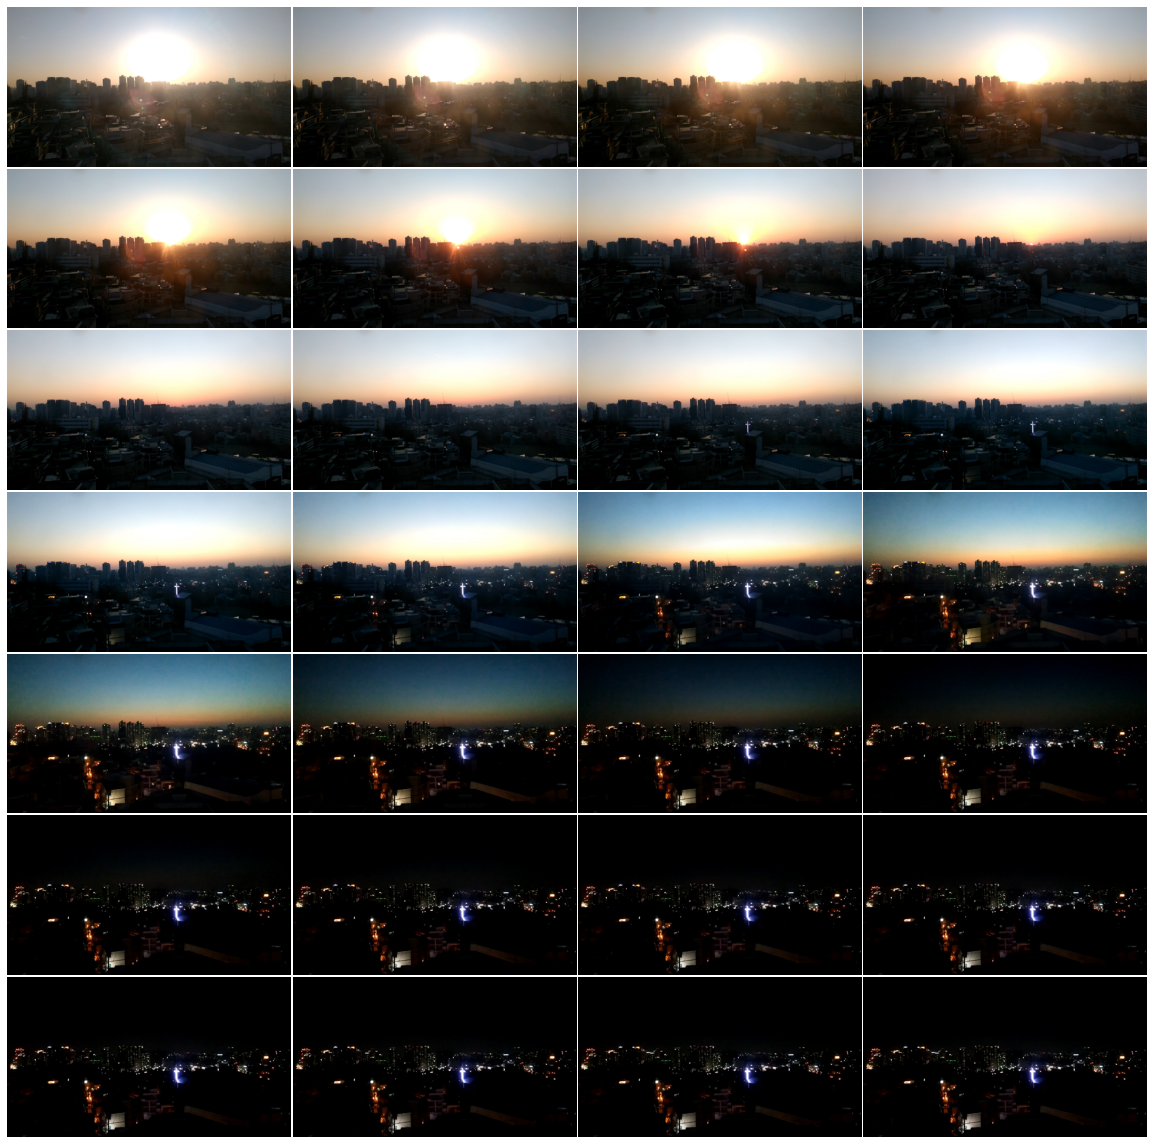

In [4]:
imgs_per_row = 4
img_scale = 4

imgs_per_col = len(imgs) // imgs_per_row
figsize = (img_scale * imgs_per_row,
           img_scale * target_im_size[1] / target_im_size[0] * imgs_per_col)
fig, axes = plt.subplots(imgs_per_col, imgs_per_row, figsize=figsize)

for i in range(imgs_per_col):
    for j in range(imgs_per_row):
        axes[i, j].imshow(get_img_from_data(imgs[i * imgs_per_row + j]))
        axes[i, j].axis('off')

fig.tight_layout(pad=0.2)
plt.show()

## PCA

Since we're aiming to plot the images on a 2D graph, we should set the number of components for the PCA to be 2:

In [5]:
pca = PCA(2)
pca.fit(imgs)

PCA(n_components=2)

### Visualizing Components

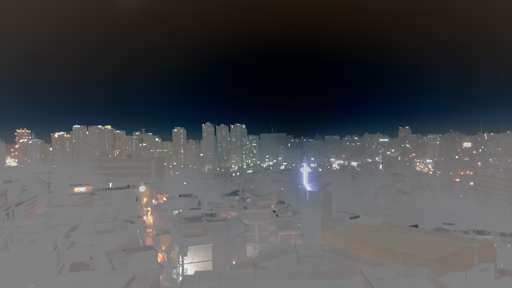

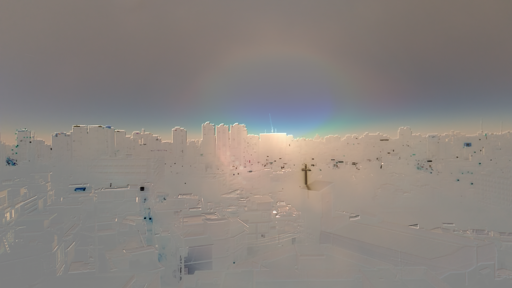

In [6]:
from IPython.display import display

for i in range(min(pca.n_components_, 10)):
    display(get_img_from_data(minmax_scale(pca.components_[i])))

As we can see, the PCA picked up on the two distinct types of pictures: taken before and after the sunset. PC1 most likley corresponds to pictures taken after the sunset since, as we can see, the sky is dark and the cross (located in the center of the picture that gets turned on at night) is very bright, while on PC2 we can see the bright sky with a glowing halo from the sun and a dark cross.

### Reconstructing Original Images

Now we can look at how the initial 28 images are preserved after being compressed into the 2d space of two principal components and reconstructed back.

In [7]:
imgs_transformed = pca.transform(imgs)

pc1 = imgs_transformed[:, 0]
pc2 = imgs_transformed[:, 1]

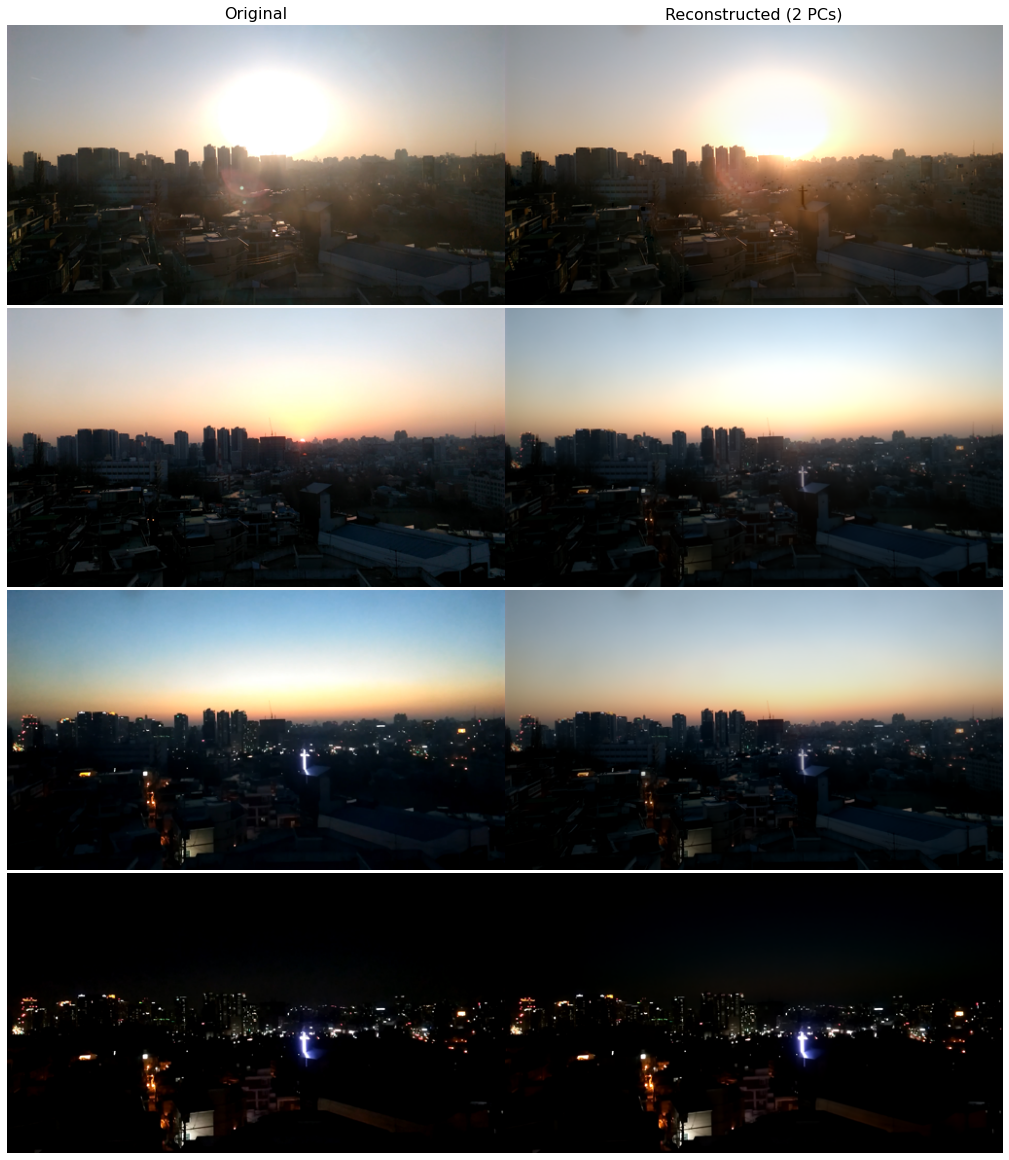

In [8]:
imgs_to_view = 4
scale = 4

fig, axes = plt.subplots(imgs_to_view, 2, figsize=(scale * 2 / target_im_size[1] * target_im_size[0], scale * imgs_to_view))

for i in range(imgs_to_view):
    img_idx = len(imgs) // imgs_to_view * i        

    axes[i, 0].imshow(get_img_from_data(imgs[img_idx]))
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(get_img_from_data(pca.inverse_transform([imgs_transformed[img_idx]])[0]))
    axes[i, 1].axis('off')

axes[0, 0].set_title("Original", fontsize=16)
axes[0, 1].set_title("Reconstructed (2 PCs)", fontsize=16)

fig.tight_layout(pad=0.3)
plt.show()

### Visualizing Images on a 2-D Plane

To pick a point far away from other components we can set its component values to maximum from both components, since neither of the pictures should have both high value on the 'night' component and a high value on the 'day' component.

In [9]:
new_point = np.array([pc1.max(), pc2.max()])

And now we can plot all of the images and the new point in a 2D graph of two principal components:

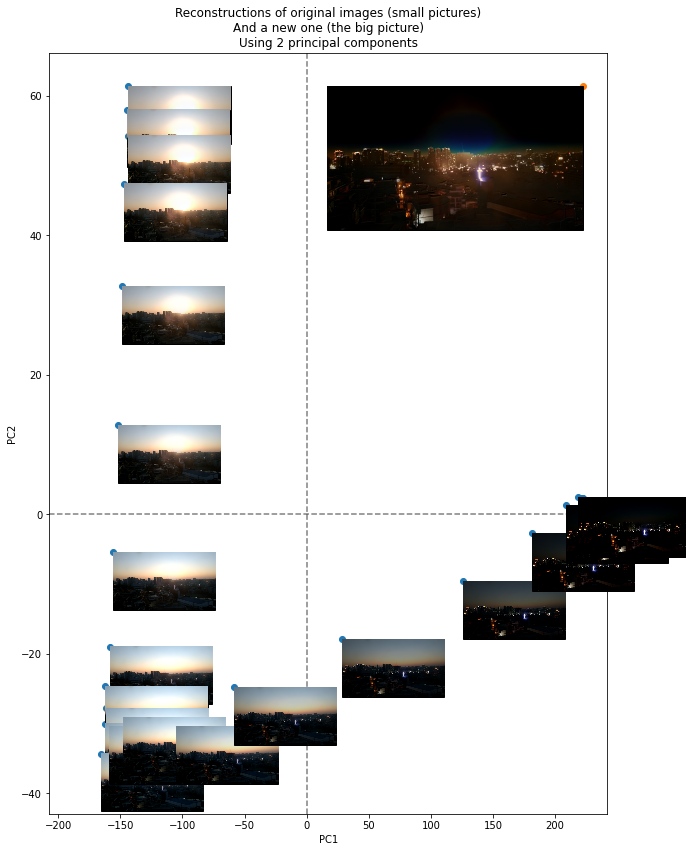

In [10]:
fig, ax = plt.subplots(figsize=(10, 14))

ax.scatter(pc1, pc2)
ax.scatter(new_point[0], new_point[1])

ax.axhline(0, ls='--', alpha=0.5, color='black')
ax.axvline(0, ls='--', alpha=0.5, color='black')

ax.set_xlim(pc1.min() * 1.25)
ax.set_ylim(pc2.min() * 1.25)

for i in range(len(imgs)):
    ax.add_artist(get_img_artist(
        pca.inverse_transform([imgs_transformed[i]])[0],  # reconstruct images from 2 components
        imgs_transformed[i], zoom=0.2, box_alignment=(0, 1)))

ax.add_artist(get_img_artist(pca.inverse_transform(new_point), new_point, zoom=0.5, box_alignment=(1, 1)))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Reconstructions of original images (small pictures)\n'
          'And a new one (the big picture)\n'
          'Using 2 principal components')
plt.show()

And we can take a closer look at the new point with the high values in both components:

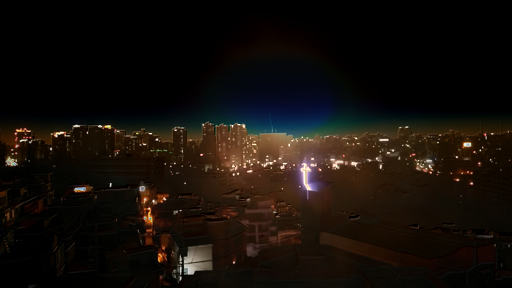

In [11]:
display(get_img_from_data(pca.inverse_transform(new_point)))

So, as we can see, it does combine the darkness of the surroundings from the first (night) component and the sun from the second (day) one.

### Out-of-bounds Images

Since we are not limited by the maximum values of the components, we can set the values on the components even higher:

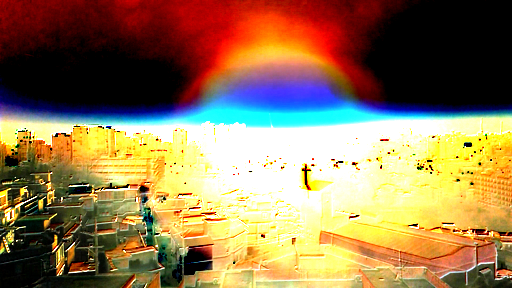

In [12]:
display(get_img_from_data(pca.inverse_transform([[100, 1000]])[0]))

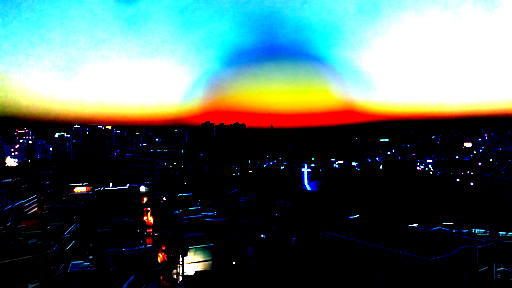

In [13]:
display(get_img_from_data(pca.inverse_transform([[-100, -1000]])[0]))

We can scatter even more images around the two components beyond their scales to get a better feel for what the components stand for: 

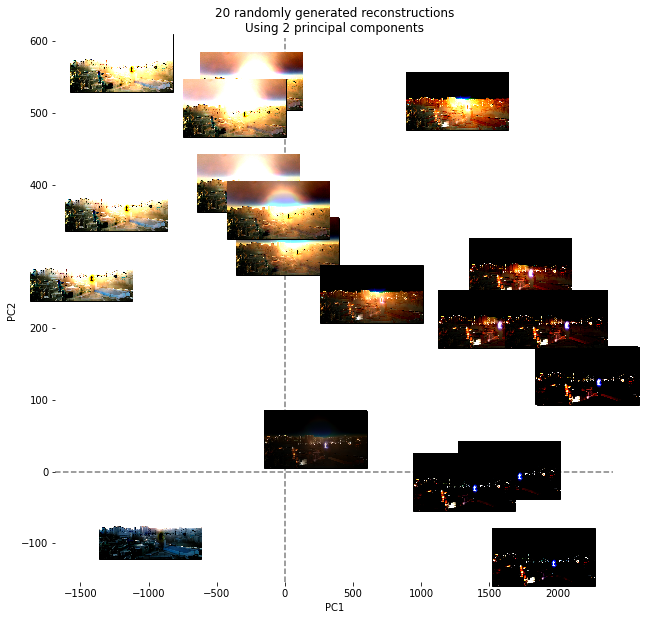

In [14]:
n_examples = 20
scale = 10
img_zoom = 0.2

pc1_min = scale * pc1.min()
pc1_max = scale * pc1.max()
pc2_min = scale * pc2.min()
pc2_max = scale * pc2.max()

new_imgs = np.array([
    np.random.randint(pc1_min, pc1_max, n_examples),
    np.random.randint(pc2_min, pc2_max, n_examples),
]).T

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(new_imgs[:, 0], new_imgs[:, 1])
ax.axhline(0, ls='--', alpha=0.5, color='black')
ax.axvline(0, ls='--', alpha=0.5, color='black')

for i in range(n_examples):
    ax.add_artist(get_img_artist(
        pca.inverse_transform([new_imgs[i]])[0],  # reconstruct images from 2 components
        new_imgs[i], zoom=img_zoom))

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(f'{n_examples} randomly generated reconstructions\n'
             'Using 2 principal components')
plt.box(on=None)
plt.show()

As we can see, PC1 indeed has to do with the darkness of the sky (and brightness of the cross) as can be seen by the fact that the more to the right an image is the darker its sky is. As for PC2, it has to do with the sun, which we can see by the fact that there is more radial glow in the center of the pictures the closer an image is to the top.

So, the PCA did manage to recognize the two most important characteristics of the image as well as use those characteristics to compress the images pretty well without losing much information, and generate new peculiar images not contained in the original set.